# Desarrollo con la base de datos Kang
En este cuaderno se recoge parte del proceso de desarrollo del Trabajo de Fin de Master.

In [1]:
!pip install tensorflow==2.15
!pip install python-dotenv
!pip install scanpy
!pip install scikit-misc
!pip install igraph
!pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
!git clone https://github.com/babelomics/ivae_scorer.git

Cloning into 'ivae_scorer'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 176 (delta 21), reused 35 (delta 10), pack-reused 119 (from 1)
Receiving objects: 100% (176/176), 72.16 MiB | 16.25 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [3]:
!pip install git+https://github.com/babelomics/ivae_scorer@develop

  Cloning https://github.com/babelomics/ivae_scorer (to revision develop) to /tmp/pip-req-build-vm19r82l
  Running command git clone --filter=blob:none --quiet https://github.com/babelomics/ivae_scorer /tmp/pip-req-build-vm19r82l
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/babelomics/ivae_scorer to commit 0f67d04a77ec157a02d74f249d6456253ec7e4ce
  Preparing metadata (setup.py) ... done
  Created wheel for ivae_scorer: filename=ivae_scorer-1.0.0-py3-none-any.whl size=528704 sha256=d4fc3a77f641482a6a444fabdfe464c3506235c09884b0d45d6fa60d30c8fd05
  Stored in directory: /tmp/pip-ephem-wheel-cache-txp2b190/wheels/f5/d0/86/8a998baa74d32887348c7f9fe7c15a843cd2cf4670f641d2fe
Successfully built ivae_scorer


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from pathlib import Path

import dotenv
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale, OneHotEncoder

from ivae_scorer.bio import (
    build_hipathia_renamers,
    get_adj_matrices,
    get_reactome_adj,
    sync_gexp_adj,
)
from ivae_scorer.datasets import load_kang
from ivae_scorer.utils import set_all_seeds
from ivae_scorer.models import build_kegg_vae

from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import TensorBoard

In [6]:
# %%
# https://www.sc-best-practices.org/conditions/gsea_pathway.html#id380
# Kang HM, Subramaniam M, Targ S, et al. Multiplexed droplet single-cell RNA-sequencing using natural genetic variation
#   Nat Biotechnol. 2020 Nov;38(11):1356]. Nat Biotechnol. 2018;36(1):89-94. doi:10.1038/nbt.4042

# %%

model_kind = "binn-reactome"
debug = 1
seed = 42
model_kind = str(model_kind)
debug = bool(int(debug))
seed = int(seed)

# Ajustar la ruta a los archivos
project_path = Path("/content/drive/MyDrive/TFM")
results_path = project_path.joinpath("results")
results_path.mkdir(exist_ok=True, parents=True)
data_path = project_path.joinpath("Datos")
data_path.mkdir(exist_ok=True, parents=True)
mygene_path = data_path.joinpath("mygene")
mygene_path.mkdir(exist_ok=True, parents=True)

set_all_seeds(seed=seed)

sc.set_figure_params(dpi=300, color_map="inferno")
sc.settings.verbosity = 1
sc.logging.print_header()

print(f"{debug=} {model_kind=}")

scanpy==1.10.2 anndata==0.10.9 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13
debug=True model_kind='binn-reactome'


In [7]:
atlas = sc.read(
    data_path.joinpath("atlas.h5ad"),
    cache=False,
)

atlas = atlas[atlas.obs["study"] != "Villani"].copy()
atlas.X = atlas.layers["counts"].copy()
sc.pp.normalize_total(atlas)
sc.pp.log1p(atlas)

In [8]:
atlas.obs.head()

,batch,chemistry,data_type,dpt_pseudotime,final_annotation,mt_frac,n_counts,n_genes,sample_ID,size_factors,species,study,tissue
index,,,,,,,,,,,,,
AAACCTGCAGCGAACA-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD16+ Monocytes,0.047970,6379.0,1862.0,0,0.957719,Human,Oetjen,Bone_Marrow
AAACCTGCATGTCCTC-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD4+ T cells,0.024928,4172.0,1082.0,0,0.425532,Human,Oetjen,Bone_Marrow
AAACCTGGTCGACTGC-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD14+ Monocytes,0.051907,6608.0,1618.0,0,0.773111,Human,Oetjen,Bone_Marrow
AAACCTGGTCGCTTCT-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,CD14+ Monocytes,0.041716,5034.0,1413.0,0,0.641188,Human,Oetjen,Bone_Marrow
AAACCTGTCCCGACTT-1-Oetjen_A,Oetjen_A,v2_10X,UMI,NaN,NKT cells,0.043522,3998.0,1127.0,0,0.452426,Human,Oetjen,Bone_Marrow


In [9]:
adata = load_kang(data_folder=data_path, normalize=False, n_genes=4000)

x_trans = adata.to_df()

obs = adata.obs

In [10]:
x_trans.shape

(24673, 15706)

In [11]:
obs.head()

,nCount_RNA,nFeature_RNA,tsne1,tsne2,condition,cluster,cell_type,replicate,nCount_SCT,nFeature_SCT,integrated_snn_res.0.4,seurat_clusters
index,,,,,,,,,,,,
AAACATACATTTCC-1,3017.0,877,-27.640373,14.966629,control,9,CD14+ Monocytes,patient_1016,1704.0,711,1,1
AAACATACCAGAAA-1,2481.0,713,-27.493646,28.924885,control,9,CD14+ Monocytes,patient_1256,1614.0,662,1,1
AAACATACCATGCA-1,703.0,337,-10.468194,-5.984389,control,3,CD4 T cells,patient_1488,908.0,337,6,6
AAACATACCTCGCT-1,3420.0,850,-24.367997,20.429285,control,9,CD14+ Monocytes,patient_1256,1738.0,653,1,1
AAACATACCTGGTA-1,3158.0,1111,27.952170,24.159738,control,4,Dendritic cells,patient_1039,1857.0,928,12,12


In [12]:
atlas_x = atlas.to_df()
atlas_obs = atlas.obs.copy()

In [13]:
obs.cell_type.unique().tolist()

['CD14+ Monocytes',
 'CD4 T cells',
 'Dendritic cells',
 'NK cells',
 'CD8 T cells',
 'B cells',
 'FCGR3A+ Monocytes',
 'Megakaryocytes']

In [14]:
atlas_obs.final_annotation.unique().tolist()

['CD16+ Monocytes',
 'CD4+ T cells',
 'CD14+ Monocytes',
 'NKT cells',
 'HSPCs',
 'CD8+ T cells',
 'Erythrocytes',
 'CD10+ B cells',
 'Plasmacytoid dendritic cells',
 'Monocyte progenitors',
 'CD20+ B cells',
 'Monocyte-derived dendritic cells',
 'Plasma cells',
 'Erythroid progenitors',
 'Megakaryocyte progenitors',
 'NK cells']

In [15]:
genes = atlas_x.columns.intersection(x_trans.columns)
x_trans = x_trans[genes]
atlas_x = atlas_x[genes]

In [16]:
circuit_adj, circuit_to_pathway_adj = get_adj_matrices(
    gene_list=x_trans.columns.to_list()
)

circuit_renamer, pathway_renamer, circuit_to_effector = build_hipathia_renamers()

kegg_circuit_names = circuit_adj.rename(columns=circuit_renamer).columns

kegg_pathway_names = circuit_to_pathway_adj.rename(columns=pathway_renamer).columns

circuit_adj.head()

x_trans, circuit_adj = sync_gexp_adj(gexp=x_trans, adj=circuit_adj)
atlas_x = atlas_x[x_trans.columns]

In [17]:
def train_val_test_split(features, val_size, test_size, stratify, seed):
    train_size = 1 - (val_size + test_size)

    x_train, x_test, y_train, y_test = train_test_split(
        features,
        stratify,
        train_size=train_size,
        stratify=stratify,
        random_state=seed,
    )

    x_val, x_test, y_val, y_test = train_test_split(
        x_test,
        y_test,
        test_size=test_size / (test_size + val_size),
        stratify=y_test,
        random_state=seed,
    )

    x_train = x_train.astype("float32")
    x_val = x_val.astype("float32")
    x_test = x_test.astype("float32")

    return x_train, x_val, x_test, y_train, y_val, y_test


def get_importances(data, abs=False):
    if abs:
        return np.abs(data).mean(axis=0)
    else:
        return data.mean(axis=0)


def get_actiations(act_model, layer_id, data):
    data_encoded = act_model.predict(data)[layer_id]
    return data_encoded

In [18]:
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
    x_trans.apply(minmax_scale),
    val_size=0.20,
    test_size=0.20,
    stratify=obs["cell_type"].astype(str) + obs["condition"].astype(str),
    seed=42,
)

y_train = obs["cell_type"][y_train.index]
y_val = obs["cell_type"][y_val.index]
y_test = obs["cell_type"][y_test.index]

label_encoder = OneHotEncoder(sparse_output=False).fit(y_train.to_frame())
y_train_encoded = label_encoder.transform(y_train.to_frame())
y_val_encoded = label_encoder.transform(y_val.to_frame())
y_test_encoded = label_encoder.transform(y_test.to_frame())

In [19]:
vae, encoder, decoder = build_kegg_vae(
    circuits=circuit_adj, pathways=circuit_to_pathway_adj, seed=seed
)

In [21]:
batch_size = 32

callback = callbacks.EarlyStopping(
    monitor="val_loss",  # Stop training when `val_loss` is no longer improving
    min_delta=1e-1,  # "no longer improving" being defined as "no better than 1e-5 less"
    patience=30,  # "no longer improving" being further defined as "for at least 3 epochs"
    verbose=0,
)

tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)
history = vae.fit(
    x_train.values,
    shuffle=True,
    verbose=0,
    epochs=100,
    batch_size=batch_size,
    callbacks=[callback, tensorboard_callback],
    validation_data=(x_val.values, None),
)

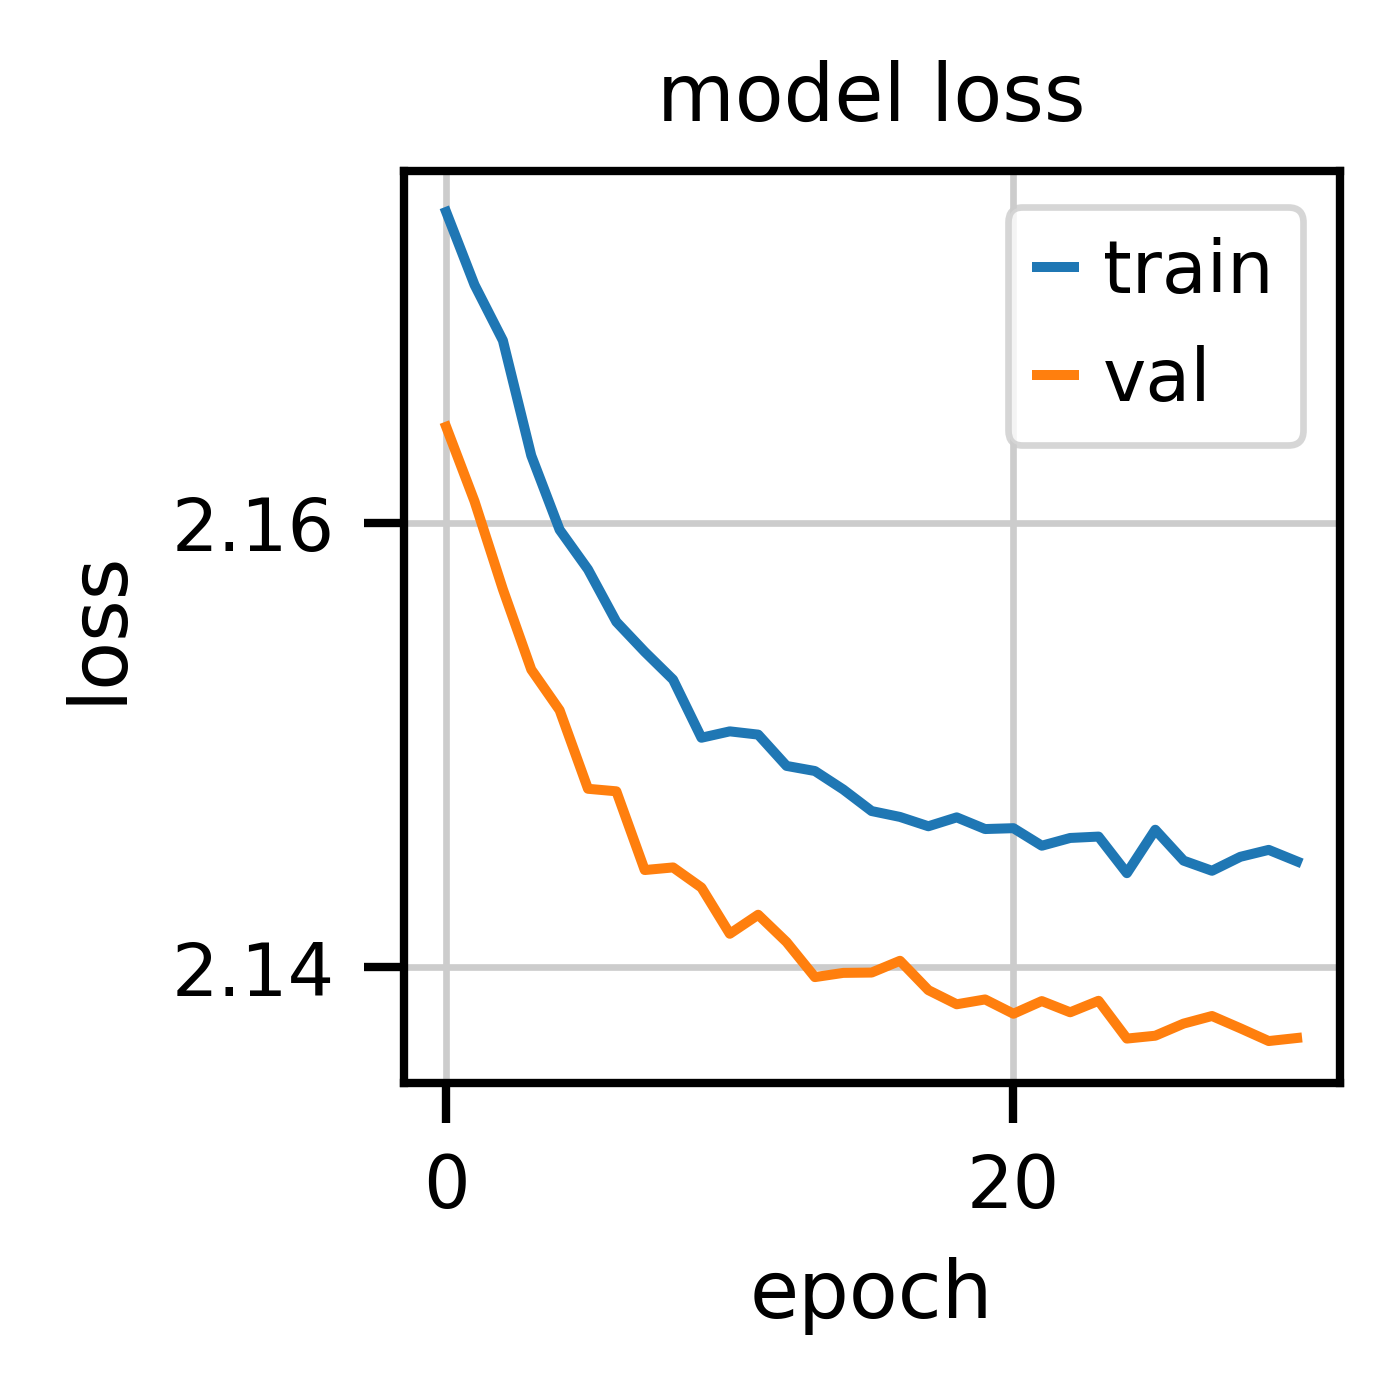

In [22]:
with sns.plotting_context("paper"):
    history.history.keys()
    # summarize history for loss
    plt.figure(figsize=(2, 2))
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"], loc="upper right")

In [23]:
x_new = pd.concat((x_test, atlas_x.apply(minmax_scale)), axis=0)
kang_obs = (
    obs.loc[x_test.index, ["cell_type", "condition"]]
    .copy()
    .rename(columns={"cell_type": "final_annotation"})
)
kang_obs["study"] = "Kang"
y_new = pd.concat(
    (kang_obs, atlas_obs[["study", "final_annotation"]].assign(condition="atlas")),
    axis=0,
)

celltypes_replace = {}
celltypes_replace["CD20+ B cells"] = "B"
celltypes_replace["B cells"] = "B"
celltypes_replace["CD4 T cells"] = "CD4+ T cells"
celltypes_replace["CD8 T cells"] = "CD8+ T cells"
celltypes_replace["CD14 Mono"] = "CD14+ Monocytes"
celltypes_replace["CD16 Mono"] = "CD16+ Monocytes"
celltypes_replace["CD16 Mono"] = "CD16+ Monocytes"
celltypes_replace["NK"] = "NK cells"
y_new = y_new.replace({"final_annotation": celltypes_replace})

In [24]:
atlas_encoded = encoder.predict(x_new, batch_size=batch_size)[0]
atlas_encoded = pd.DataFrame(atlas_encoded, index=x_new.index)

adata = sc.AnnData(X=atlas_encoded)
adata.obs = y_new.loc[x_new.index]

# sc.pp.log1p(adata)
sc.pp.neighbors(adata, use_rep="X", random_state=42)
sc.tl.leiden(adata, random_state=42)
sc.tl.umap(adata, random_state=42)
sc.pl.umap(
    adata, color=["study", "final_annotation", "condition"], frameon=False, ncols=2
)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
sc.pl.umap(
    adata,
    color=["condition", "final_annotation"],
    frameon=False,
    ncols=1
    )

Output hidden; open in https://colab.research.google.com to view.

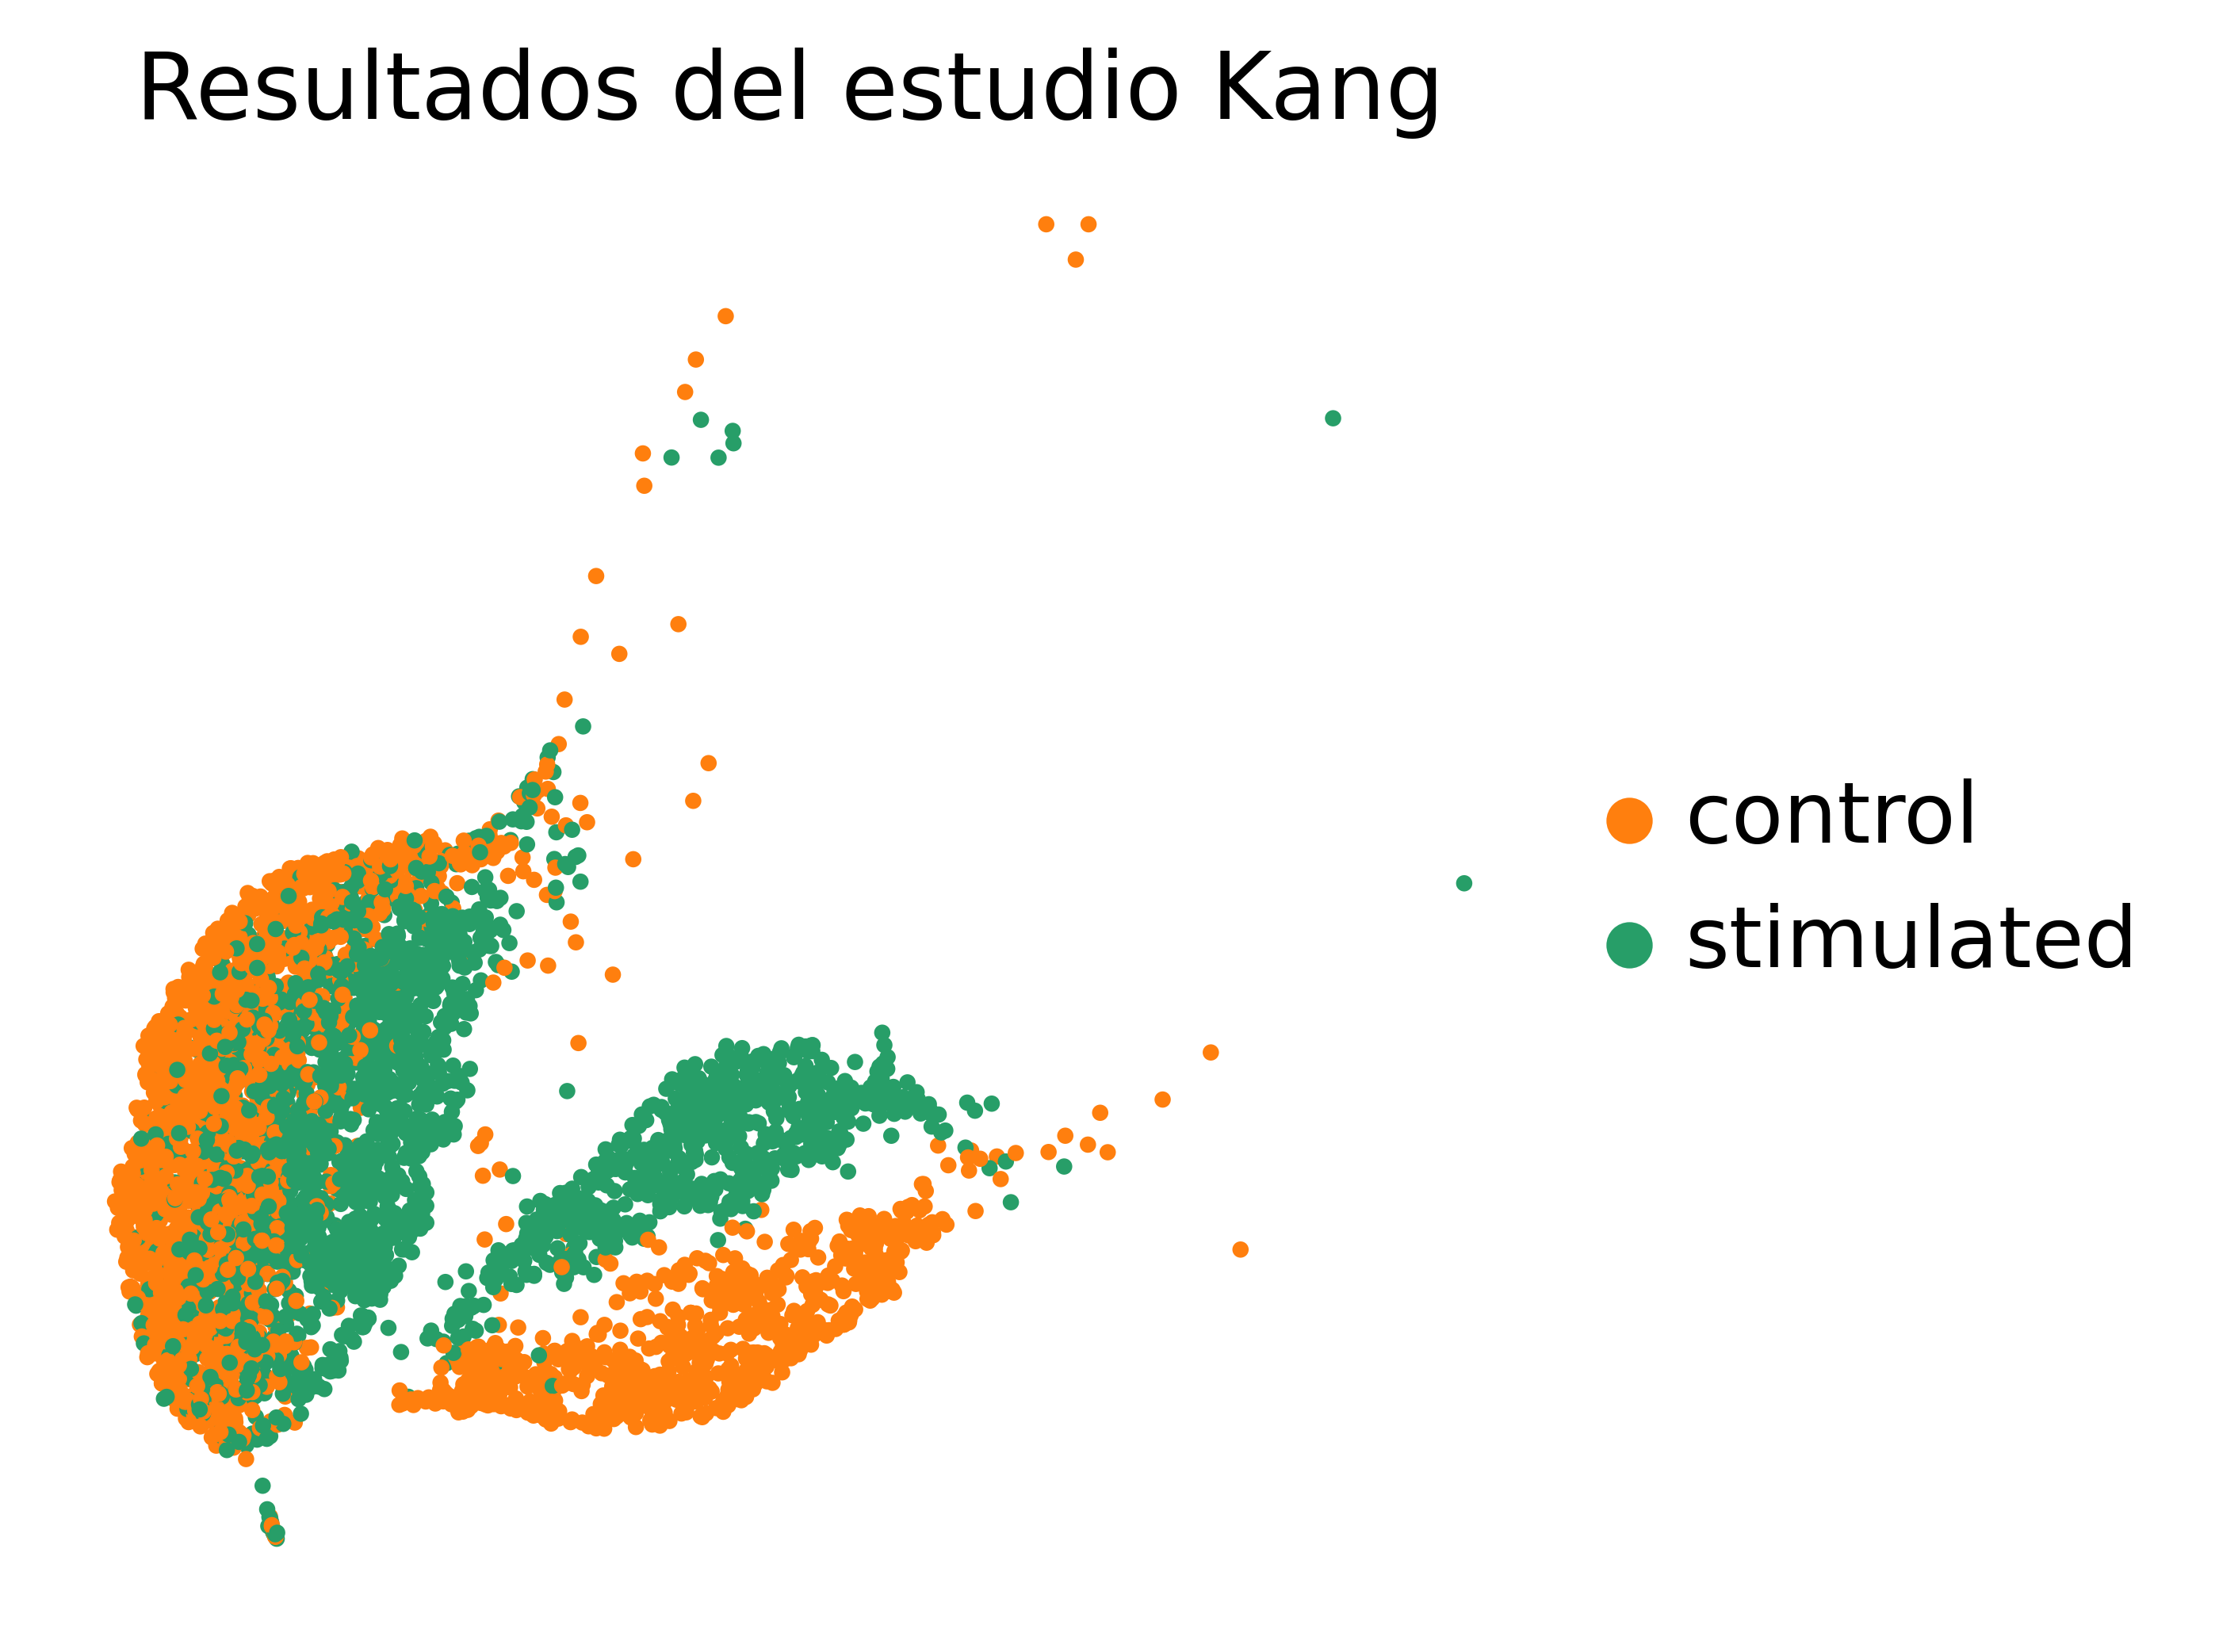

In [26]:
kang_data = adata[adata.obs["study"] == "Kang"]

# Generar la visualización UMAP con los datos de Kang
sc.pl.umap(kang_data, color=["condition"], title="Resultados del estudio Kang", frameon=False,
    ncols=1)

In [37]:
kang_data.obs['final_annotation'].unique()

['Dendritic cells', 'B', 'FCGR3A+ Monocytes', 'CD14+ Monocytes', 'NK cells', 'CD4+ T cells', 'CD8+ T cells', 'Megakaryocytes']
Categories (8, object): ['B', 'CD4+ T cells', 'CD8+ T cells', 'CD14+ Monocytes',
                         'Dendritic cells', 'FCGR3A+ Monocytes', 'Megakaryocytes', 'NK cells']

In [35]:
final_annotations = kang_data.obs['final_annotation'].unique()

n_types = len(final_annotations)
n_cols = 2
n_rows = int(np.ceil(n_types / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, final_annotation in enumerate(final_annotations):
    subset = kang_data[kang_data.obs['final_annotation'] == final_annotation]

    sc.pl.umap(
        subset,
        color='condition',
        ax=axes[i],
        frameon=False,
        title=f'UMAP for {final_annotation}',
        show=False
    )
    axes[i].set_title(f'UMAP for {final_annotation}')
    axes[i].legend(title='Condition')

plt.tight_layout()
plt.show()

In [36]:
fig.savefig('umap_by_cell_type.png', dpi=300)